In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import glob
%matplotlib nbagg
# %matplotlib
# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/GaussianProcess/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="1" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [9]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

In [3]:
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [4]:
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_noFeatureCenter.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_smallShift.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_WhiteNoise.h5'
model_path = 'CNNmodels/VGG16_usim_40mradEmit+defocus_noApt.h5'
# model_path = 'CNNmodels/VGG16_30mrademit+defocus_30mradApt_lowAbr_test12_05.h5' 

In [5]:
model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1,activation=None))
new_model = Sequential()

for l in model.layers:
    new_model.add(l)

new_model.add(top_model)
new_model.load_weights(model_path)

In [6]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [7]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [27]:
abr_list = ["C10", "C12.x", "C12.y", "C21.x", "C21.y", "C23.x", "C23.y", "C30", 
"C32.x", "C32.y", "C34.x", "C34.y"]

abr_lim = [2e-6, 2e-6, 2e-6, 3e-5, 3e-5, 3e-5, 3e-5, 4e-4, 3e-4, 3e-4, 2e-4, 2e-4]
abr_default = [2e-9, 2e-9, 2e-9, 20e-9, 20e-9, 20e-9, 20e-9, 0.5e-6, 1e-6, 1e-6, 1e-6, 1e-6]

In [86]:
abr_coeff = 'C12'
path = '../NionData/LineScans_070121/50ms-2/'
file_list = glob.glob(path + abr_coeff +'*50ms_bin1_repx5maxFOV.npy')
print(file_list)

['../NionData/LineScans_070121/50ms-2/C12.x_2e-06m_100steps_50ms_bin1_repx5maxFOV.npy', '../NionData/LineScans_070121/50ms-2/C12.y_2e-06m_100steps_50ms_bin1_repx5maxFOV.npy']


In [87]:
# ronch_list = np.load('NionRelated/C12.y_2e-06m_100steps_10ms_bin8.npy')
nsteps = 100
nrep = 5
x_list = []
y_list = []
t_list = []
coeff_list = []
x_default = [(abr_default[i] + abr_lim[i]/2) / abr_lim[i] for i in range(len(abr_list))]

for file in file_list:
    name_list = file.replace('/','_').split('_')
    print(file, name_list)
    abr_coeff = name_list[5]
    idx = abr_list.index(abr_coeff)
    abr_range = abr_lim[idx]
    value_list = [(i - nsteps//2) * abr_range / nsteps for i in range(nsteps)]
    ronch_list = np.load(file)
    frame_list = []
#     print(abr_range, value_list)
    
    for i in range(nsteps):
        for j in range(5):
            x = [x_default[j] for j in range(len(x_default))]
            x[idx] = (value_list[i] + abr_range / 2) / abr_range
            x_list.append(x)
            frame = ronch_list[i * nrep + j,:,:]
            frame = scale_range(frame, 0, 1)
    #         frame = frame * aperture_generator(128, 50, 40)
            new_channel = np.zeros(frame.shape)
            img_stack = np.dstack((frame, new_channel, new_channel))
            frame_list.append(img_stack)
    frame_list = np.concatenate([arr[np.newaxis] for arr in frame_list])
    prediction = new_model.predict(frame_list, batch_size = 1)
    y_list.append((1 - prediction[:,0])[:])
    t_list.append(name_list[-2])
    coeff_list.append(abr_coeff)

../NionData/LineScans_070121/50ms-2/C12.x_2e-06m_100steps_50ms_bin1_repx5maxFOV.npy ['..', 'NionData', 'LineScans', '070121', '50ms-2', 'C12.x', '2e-06m', '100steps', '50ms', 'bin1', 'repx5maxFOV.npy']
../NionData/LineScans_070121/50ms-2/C12.y_2e-06m_100steps_50ms_bin1_repx5maxFOV.npy ['..', 'NionData', 'LineScans', '070121', '50ms-2', 'C12.y', '2e-06m', '100steps', '50ms', 'bin1', 'repx5maxFOV.npy']


<IPython.core.display.Javascript object>


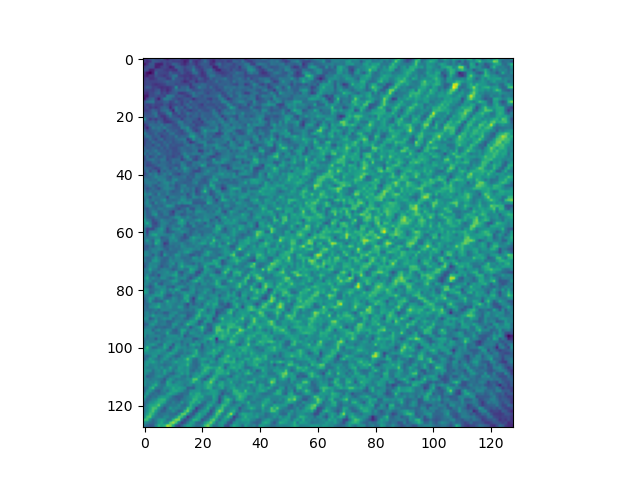

In [88]:
plt.imshow(ronch_list[20])

<IPython.core.display.Javascript object>


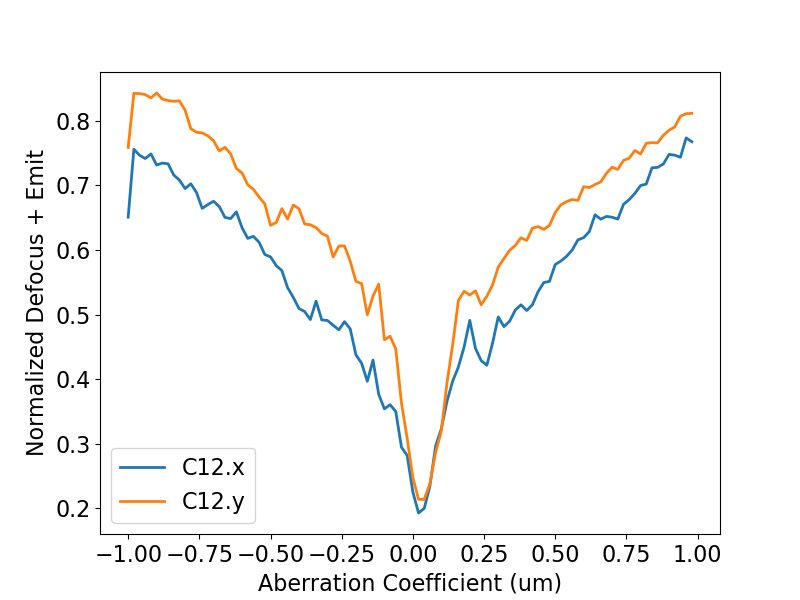

In [89]:
fig, ax = plt.subplots(1,1, figsize = [8,6])
for i in range(len(t_list)):
#     p = ax.plot(np.array(value_list)[np.where(np.array(value_list) != 0)]*1e6, 1-y_list[i], linewidth = 2, 
#                label = t_list[i])
    p = ax.plot(np.array(value_list) * 1e6, 1 - y_list[i].reshape([nsteps, 5]).mean(-1), linewidth = 2, label = coeff_list[i])
ax.set_xlabel('Aberration Coefficient (um)',fontsize = 16)
ax.set_ylabel('Normalized Defocus + Emit', fontsize = 16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.legend(fontsize = 16)

In [ ]:
len(ronch_list)
plt.imshow(ronch_list[-1,:,:])

In [13]:
y_list = np.ndarray.flatten(np.asarray(y_list))
print(y_list.shape)

(1200,)


In [14]:
x_list = np.asarray(x_list)
print(x_list.shape)

(1200, 12)


In [35]:
np.save('NionRelated/X_usim_linescan_100steps_50ms_bin1_rep5.npy', x_list)
np.save('NionRelated/Y_usim_linescan_100steps_50ms_bin1_rep5.npy', y_list)

In [15]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import time
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [16]:
# x_list = np.load('NionRelated/X_usim_linescan_100steps_50ms_bin1_rep5.npy')
# y_list = np.load('NionRelated/Y_usim_linescan_100steps_50ms_bin1_rep5.npy')

# combine the data from linescans and the data from a test GP run

X = pd.DataFrame(x_list)
Y = pd.DataFrame(y_list).squeeze()

print('Y.shape',Y.shape,'\nX.shape',X.shape)

Y.shape (1200,) 
X.shape (1200, 12)


In [17]:
from Modules.tfgp_trainer import tfgp_trainer
tf.compat.v1.disable_eager_execution()

In [18]:
Niter = 1500

t0 = time.time()
tfgp = tfgp_trainer(X, Y,verbose=0)

tfgp.train(lr=0.005, 
           niter=Niter,
           optimizer=[tf.compat.v1.train.AdamOptimizer, tf.optimizers.SGD, tf.optimizers.RMSprop][0],
           gradient_clipping=0,
           kernel=['rbf','matern32','matern52'][0],
           correlations = False,
           offset = False,
           monitor_period=None,
           monitor_gradient=None) 

tfgp_t = time.time()-t0
print ('took ',tfgp_t ,' seconds')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


N/A% (0 of 1500) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--


ResourceExhaustedError: OOM when allocating tensor with shape[1200,1200] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mul_4 (defined at /home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/Modules/tfgp_trainer.py:214) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Errors may have originated from an input operation.
Input Source operations connected to node mul_4:
 Exp_3 (defined at /home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/Modules/tfgp_trainer.py:136)

Original stack trace for 'mul_4':
  File "/home/chenyu/anaconda3/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/chenyu/anaconda3/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/home/chenyu/anaconda3/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/home/chenyu/anaconda3/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/home/chenyu/anaconda3/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 688, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/ioloop.py", line 741, in _run_callback
    ret = callback()
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 814, in inner
    self.ctx_run(self.run)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 381, in dispatch_queue
    yield self.process_one()
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 250, in wrapper
    runner = Runner(ctx_run, result, future, yielded)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 741, in __init__
    self.ctx_run(self.run)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 775, in run
    yielded = self.gen.send(value)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 268, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 545, in execute_request
    user_expressions, allow_stdin,
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tornado/gen.py", line 234, in wrapper
    yielded = ctx_run(next, result)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 306, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2887, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2932, in _run_cell
    return runner(coro)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3156, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3347, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-381d8d725cd6>", line 14, in <module>
    monitor_gradient=None)
  File "/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/Modules/tfgp_trainer.py", line 298, in train
    loglik  = self.logLikelihood(X, y, alpha, noise, precision_matrix, kernel)
  File "/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/Modules/tfgp_trainer.py", line 214, in logLikelihood
    KK = tf.abs(alpha) * K + (tf.abs(noise) + self.jitter) * tf.eye(sizeX, dtype=tf.float64)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 984, in binary_op_wrapper
    return func(x, y, name=name)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py", line 1283, in _mul_dispatch
    return gen_math_ops.mul(x, y, name=name)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/gen_math_ops.py", line 6092, in mul
    "Mul", x=x, y=y, name=name)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 744, in _apply_op_helper
    attrs=attr_protos, op_def=op_def)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3327, in _create_op_internal
    op_def=op_def)
  File "/home/chenyu/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1791, in __init__
    self._traceback = tf_stack.extract_stack()


In [ ]:
from Modules.utils import GP_plot_results
tfgp_results = GP_plot_results(tfgp,Y)

In [ ]:
from Modules.sk_trainer import sk_trainer
sk=sk_trainer()
sk.sk_train(X, Y, kernels=['rbf'], offset=False, verboseQ=True, saveQ=False)

In [ ]:
from Modules.gpy_trainer import gpy_trainer
gpy=gpy_trainer()
gpy.gpy_train(X, Y[:,None], kernels= ['rbf'], max_iters=5000, offset=False, verboseQ=True, saveQ=False)

In [ ]:
# collect the results into a pandas dataframe to display
pd.DataFrame({"Param": ['time','negative log likelihood', 'amplitude', 'noise', 'offset'],
              "tfgp": [tfgp_t, tfgp_results['ll'], tfgp_results['amp_param'], tfgp_results['noise_param_variance'] , tfgp_results['offset_param']],
              "SK": [sk.sk_t, sk.results['ll'], sk.results['amp_param'], sk.results['noise_param_variance'] , sk.results['offset_param']],
              "GPy": [gpy.gpy_t, gpy.results['ll'], gpy.results['amp_param'], gpy.results['noise_param_variance'] , gpy.results['offset_param']],
             })


In [ ]:
print('Lengthscales Comparison')
pd.DataFrame({"": X.keys(),
#               "Param":['HP','HP diff','S6','S7','OBJ','S3','S4'],
              "tfgp": tfgp_results['length_scale_param'],
              "SK": sk.results['length_scale_param'] ,
              "GPy": gpy.results['length_scale_param']
             })